<a href="https://colab.research.google.com/github/kirthikalikar/HawkEye/blob/main/HawkEye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [182]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [183]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

In [184]:
data = pd.read_csv('/content/malicious_phish.csv')
data=data.dropna()
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 14.9+ MB


In [186]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [187]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

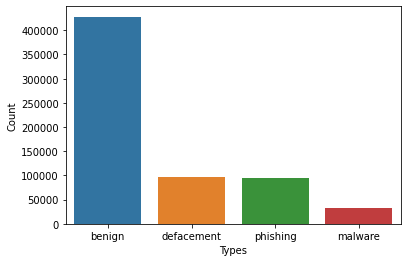

In [188]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [189]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [190]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [191]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

In [192]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [193]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [194]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [195]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [196]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [197]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [198]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [199]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

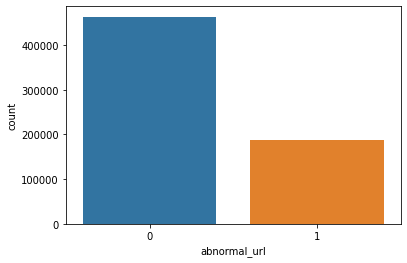

In [200]:
sns.countplot(x='abnormal_url', data=data);

In [201]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [202]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

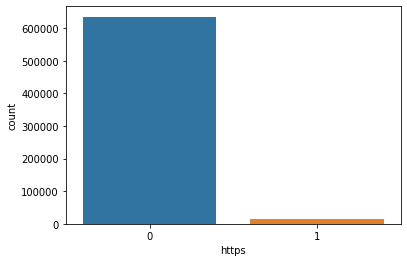

In [203]:
sns.countplot(x='https', data=data);

In [204]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [205]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [206]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [207]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [208]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [209]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

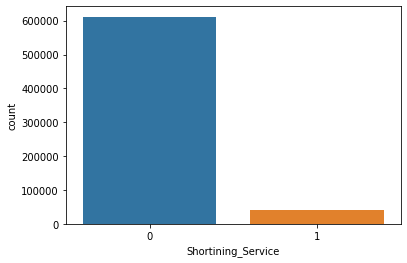

In [210]:
sns.countplot(x='Shortining_Service', data=data);

In [211]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [212]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [213]:
data['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

<AxesSubplot:>

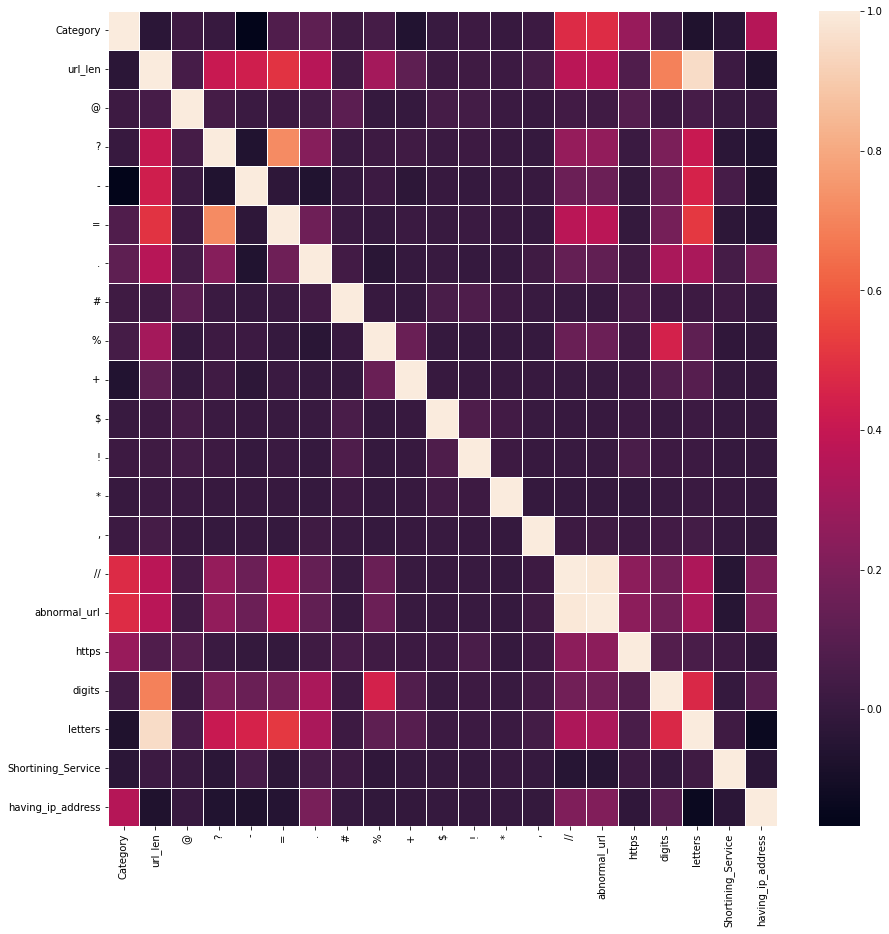

In [214]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [215]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [217]:
X_train.head()

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
510482,31,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,26,0,0
194358,86,0,0,7,0,1,0,0,0,0,0,0,0,1,1,0,6,65,0,0
611258,90,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,6,73,0,0
417382,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,0,0
225565,80,0,0,8,0,1,0,0,0,0,0,0,0,0,0,0,0,69,0,0


In [218]:
y_train.head()

510482    0
194358    0
611258    2
417382    0
225565    0
Name: Category, dtype: int64

In [219]:
y.head()

0    2
1    0
2    0
3    1
4    1
Name: Category, dtype: int64

In [220]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.49%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.58      0.68     18805
           3       0.96      0.91      0.94      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


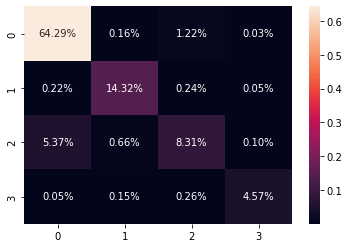

###################- End -###################


In [221]:
models = [DecisionTreeClassifier,RandomForestClassifier, ExtraTreesClassifier]
accuracy_test=[]
m=RandomForestClassifier
print('#############################################')
print('######-Model =>\033[07m {} \033[0m'.format(m))
model_ = m()
model_.fit(X_train, y_train)
pred = model_.predict(X_test)
acc = accuracy_score(pred, y_test)
accuracy_test.append(acc)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')

In [222]:
def preprocess(url):
  df = pd.DataFrame({'url':[url],'type':['unknown']})
  print(df)
  df['url'] = df['url'].replace('www.', '', regex=True)
  df['Category'] = df['type']
  df = df.replace(rem)
  df['url_len'] = df['url'].apply(lambda x: len(str(x)))
  process_tld(url)
  df['domain'] = df['url'].apply(lambda i: process_tld(i))
  print(df)
  feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
  for a in feature:
      df[a] = df['url'].apply(lambda i: i.count(a))
  df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
  df['https'] = df['url'].apply(lambda i: httpSecure(i))
  df['digits']= df['url'].apply(lambda i: digit_count(i))
  df['letters']= df['url'].apply(lambda i: letter_count(i))
  df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))
  df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))
  df['having_ip_address'].value_counts()
  X = df.drop(['url','type','Category','domain'],axis=1)#,'type_code'
  return X

In [249]:
model=preprocess("http://bdnews24.com/bangladesh/2015/05/12/human-traffickers-held-with-fake-passports-in-ctg")

                                                 url     type
0  http://bdnews24.com/bangladesh/2015/05/12/huma...  unknown
                                                 url     type Category  \
0  http://bdnews24.com/bangladesh/2015/05/12/huma...  unknown  unknown   

   url_len        domain  
0       91  bdnews24.com  


In [251]:
pred = model_.predict(model)
print (pred)

[0]
